In [1]:
import pickle
from pathlib import Path
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, TwoSlopeNorm
from lameg.util import get_files, make_directory, check_many
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr, mode
from scipy.spatial import KDTree
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import itertools as it

In [2]:
def annotate_mx(im, txt_mx, **textkw):
    kw = dict(
        horizontalalignment="center",
        verticalalignment="center"
    )
    kw.update(textkw)
    for r, c in it.product(range(txt_mx.shape[0]), range(txt_mx.shape[1])):
        im.axes.text(r, c, txt_mx[r, c], **kw)

def colorbar(mappable, label):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar


def plot_mx(mx, LAB, title="", ax=False, labels=False, cbar=False, cmap="Spectral_r", norm=False, cbar_label=r"$\Delta$ FE"):
    if not ax:
        f, ax = plt.subplots(1, 1)
    else:
        ax = ax
    if not norm:
        iw = ax.imshow(mx.T, cmap=cmap)
    else:
        iw = ax.imshow(mx.T, cmap=cmap, norm=norm)
    if labels:
        ax.set_ylabel("Evaluation Surface")
        ax.set_xlabel("Simulation Surface")
        ax.set_xticks(np.arange(11).astype(int))
        ax.set_xticklabels(LAB)
        ax.set_yticks(np.arange(11).astype(int))
        ax.set_yticklabels(LAB)
        plt.suptitle(title)
        plt.tight_layout()
    if cbar:
        colorbar(iw, cbar_label)
    return iw

def find_peaks(mx, marker="*", return_annot=True):
    annot = np.zeros(mx.shape).astype(np.object_)
    peaks = []
    for l in range(mx.shape[0]):
        peak = np.argmax(mx[l, :]) # here is the problem (you find peak in evaluated!)
        annot[peak, l] = 1.0
#         peak = np.argmax(mx[:, l])
#         annot[l, peak] = 1.0
        peaks.append(peak)
    peaks = np.array(peaks)
    annot_bin = np.copy(annot).astype(float)
    annot[annot==0.0] = None
    annot[annot==1.0] = marker
    if return_annot:
        return peaks, annot, annot_bin
    else:
        return peaks
    

def compare_values_with_threshold(a, b, c, threshold=5):
    def compare(x, y, threshold):
        # Consider values equal if the difference is smaller than or equal to threshold
        if abs(x - y) <= threshold:
            return 0
        elif x < y:
            return -1
        else:
            return 1

    # Compare all pairs with the threshold
    result_ab = compare(a, b, threshold)
    result_ac = compare(a, c, threshold)
    result_bc = compare(b, c, threshold)

    return result_ab, result_ac, result_bc


In [3]:
order_ = [list(i) for i in list(it.product(list(np.arange(11)), [5]))]
order_fix = []
for i in order_:
    if np.unique(i).shape[0] == 1:
        order_fix.append([i[0]])
    else:
        order_fix.append(i)

n_layers = 11
layers = np.arange(n_layers).astype(int)
LAB = list(layers)
LAB[0] = "P"
LAB[-1] = "W"

In [4]:
folder_path = Path("/scratch/coreg_analysis/mid_sd_iteration_2_source_snr")

In [5]:
all_files = get_files(folder_path, "*.pickle", strings=["mid_sd"])

In [6]:
df_files = {
    "filename": [],
    "snr": [],
    "base_vertex": [],
    "layers_used": [],
    "layerF":[],
    "layerF_abs":[]
}

for file_path in all_files:
    with open(file_path, "rb") as file:
        data = pickle.load(file)
    
    df_files["filename"].append(file_path)
    df_files["base_vertex"].append(data["base_vertex"])
    df_files["layers_used"].append(order_fix.index(data["layers_used"]))
    df_files["snr"].append(data["snr"])
    
    lFdata = None
    if len(data["layerF"].shape) == 2:
        lFdata = data["layerF"][0]
    else:
        lFdata = data["layerF"]
    
    df_files["layerF"].append(lFdata - np.min(lFdata))
    df_files["layerF_abs"].append(lFdata)

In [7]:
full_df = pd.DataFrame.from_dict(df_files)

In [17]:
full_df.loc[
    (full_df.base_vertex == 26967) &
    (full_df.snr == -) &
    (full_df.layers_used == 0)
]

,filename,snr,base_vertex,layers_used,layerF,layerF_abs
4890,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,-20,26967,0,"[300.74932563161747, 320.5393693714241, 328.89...","[-6127.172849098577, -6107.38280535877, -6099...."


In [8]:
snrs = full_df.snr.unique()
base_vertices = full_df.base_vertex.unique()

full_df.head()

,filename,snr,base_vertex,layers_used,layerF,layerF_abs
0,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,-500,161,0,"[35.804725716792746, 62.94099298208312, 0.0, 2...","[-66347.48300903903, -66320.34674177374, -6638..."
1,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,-500,26557,10,"[35.80388605572807, 62.94667510202271, 0.0, 20...","[-65934.66811368881, -65907.52532464251, -6597..."
2,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,-500,26967,0,"[35.80339543860464, 62.94131157291122, 0.0, 20...","[-66588.52897572849, -66561.39105959419, -6662..."
3,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,-500,26967,1,"[35.803396314848214, 62.94131395674776, 0.0, 2...","[-66579.22029634356, -66552.08237870166, -6661..."
4,/scratch/coreg_analysis/mid_sd_iteration_2_sou...,-500,26967,2,"[35.8033913566469, 62.94131097463833, 0.0, 20....","[-66573.79131163402, -66546.65339201603, -6660..."


In [9]:
source_dist = np.zeros((n_layers, n_layers)).astype(np.object_)
source_dist[source_dist == 0] = None
for i in order_:
    source_dist[i[0], i[0]] = r"$\bullet$"
    source_dist[i[0], i[1]] = r"$\bullet$"

array([[-5733.48362595, -5660.49835342, -5590.47290833, -5584.01694115,
        -5641.43526076, -5736.66601187, -5874.34427376, -6092.83238338,
        -6333.56538959, -6560.28730672, -6770.8019869 ],
       [-5779.37624132, -5693.81409306, -5603.0831028 , -5582.05465245,
        -5617.18483476, -5695.85212088, -5817.26939493, -6016.94744849,
        -6240.89186888, -6454.24076657, -6653.64413117],
       [-5870.71742041, -5764.47734906, -5637.51579864, -5591.77458299,
        -5587.74563438, -5637.84839335, -5731.22176181, -5897.79507386,
        -6093.75442106, -6284.08843934, -6465.22155278],
       [-5944.44698685, -5823.78935145, -5672.34713605, -5609.58280204,
        -5579.06290269, -5609.5869676 , -5683.69912019, -5827.72991471,
        -6003.87014967, -6178.42612456, -6346.54791942],
       [-6077.10863923, -5934.51547742, -5744.47667995, -5655.35616854,
        -5582.90571759, -5582.80907842, -5626.79982656, -5735.21192351,
        -5880.54623437, -6031.19620944, -6179.076031

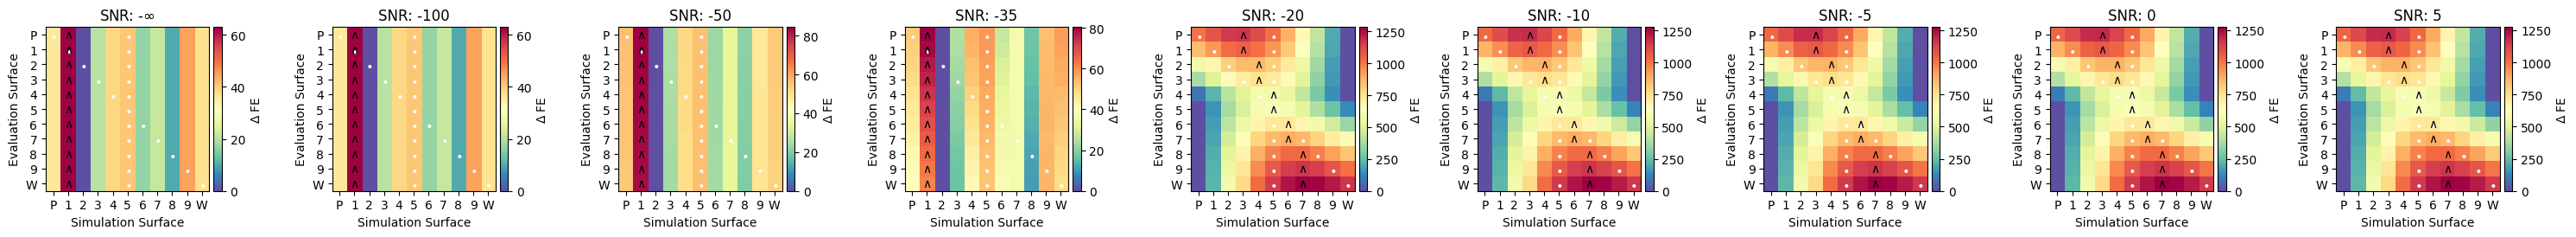

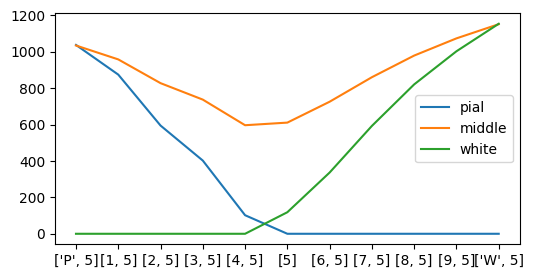

In [15]:
labs = ["pial", "middle", "white"]
base_vertex = base_vertices[75]

f, ax = plt.subplots(1, snrs.shape[0], figsize=(30, 3), facecolor="white")
for snr_ix, snr in enumerate(snrs):
    if snr_ix == 0:
        ax[snr_ix].set_title(r"SNR: -$\infty$")
    else:
        ax[snr_ix].set_title(f"SNR: {snr}")
    
    mx = np.vstack(full_df.loc[
        (full_df.base_vertex == base_vertex) &
        (full_df.snr == snr)
    ].layerF.to_list())
    
    mx_abs = np.vstack(full_df.loc[
        (full_df.base_vertex == base_vertex) &
        (full_df.snr == snr)
    ].layerF_abs.to_list())
    peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
    iw = plot_mx(np.rot90(np.fliplr(mx)), LAB, ax=ax[snr_ix], labels=True, cbar=True, cbar_label=r"$\Delta$ FE")
    annotate_mx(iw, source_dist.T, c="white")
    annotate_mx(iw, annot)    
    
plt.tight_layout()

f, ax = plt.subplots(1,1, figsize=(6,3))






for ordr, ix in enumerate([0, 5, -1]):
    ax.plot(np.arange(n_layers), mx[:, ix], label=labs[ordr])
ax.legend()
ax.set_xticks(np.arange(n_layers))
ax.set_xticklabels([str([LAB[x] for x in i]) for i in order_fix]);

mx_abs

In [19]:
labs = ["pial", "middle", "white"]

comparisons = [[0, 1], [0, 2], [1, 2]]
comp_labs = [[labs[j] for j in i] for i in comparisons]
comp_col = {
    0: "#fe4a49",
    1: "#fed766",
    2: "#009fb7",
}

labs = ["pial", "middle", "white"]
lab_col = {
    "pial": "#fe4a49",
    "middle": "#fed766",
    "white": "#009fb7",
}

In [21]:
matrices_all = {i: [] for i in snrs}
peaks_all = {i: [] for i in snrs}
annots_bin = {i: [] for i in snrs}
pwm_dfe = {i: [] for i in snrs}
bin_comp = {i: [] for i in snrs}

for base_vertex in base_vertices:
    for snr_ix, snr in enumerate(snrs):
        mx = np.vstack(full_df.loc[
            (full_df.base_vertex == base_vertex) &
            (full_df.snr == snr)
        ].layerF.to_list())
        
        mx_abs = np.vstack(full_df.loc[
            (full_df.base_vertex == base_vertex) &
            (full_df.snr == snr)
        ].layerF_abs.to_list())

        peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
        matrices_all[snr].append(mx)
        peaks_all[snr].append(peaks)
        annots_bin[snr].append(annots_bin)
        
        pmw_abs = mx_abs[:,[0, 5, -1]].T
        pmw_rel = pmw_abs - np.min(pmw_abs, axis=0)
        
        pwm_dfe[snr].append(pmw_rel)
        pwm_bin = np.array([compare_values_with_threshold(*pmw_rel[:,i], threshold=50) for i in np.arange(n_layers)])                
        bin_comp[snr].append(pwm_bin)

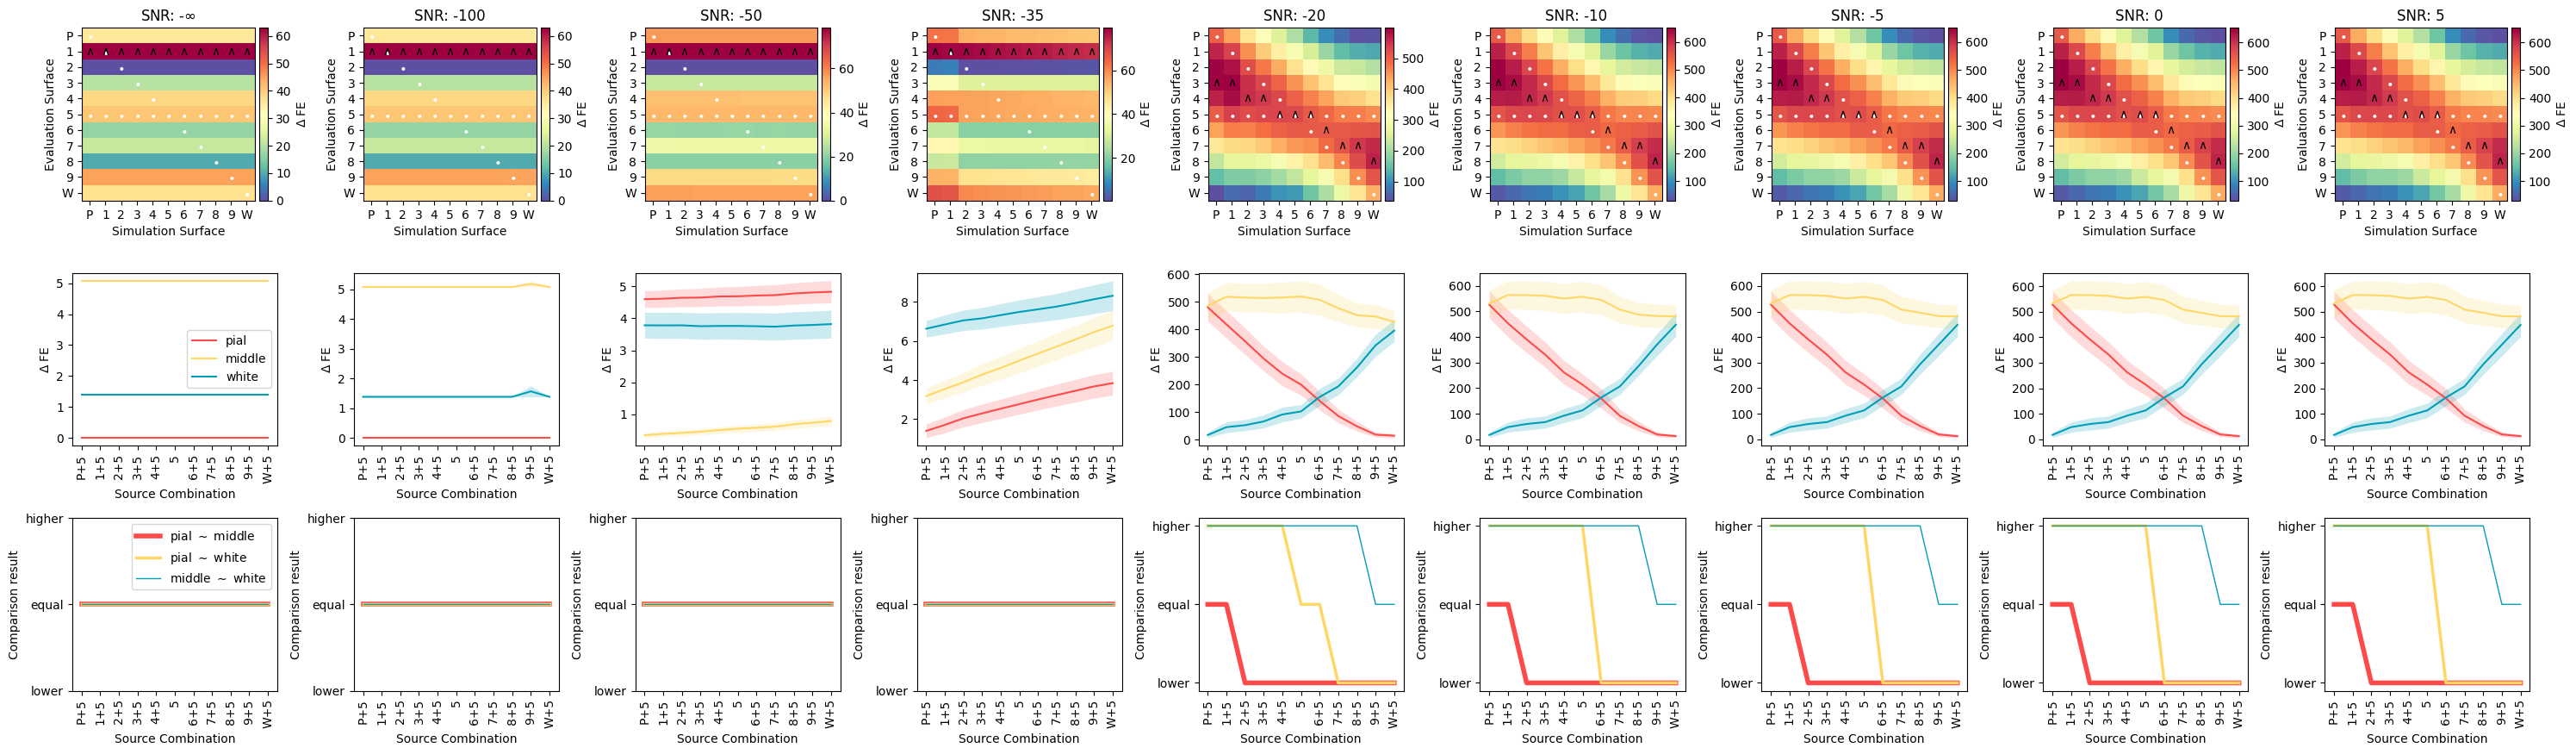

In [22]:
f, ax = plt.subplots(3, snrs.shape[0], figsize=(30, 9), facecolor="white")
for snr_ix, snr in enumerate(snrs):
    if snr_ix == 0:
        ax[0,snr_ix].set_title(r"SNR: -$\infty$")
    else:
        ax[0,snr_ix].set_title(f"SNR: {snr}")
    mx = np.mean(matrices_all[snr], axis=0)
    peaks, annot, annot_bin = find_peaks(mx, marker=r"$\wedge$")
    iw = plot_mx(mx, LAB, ax=ax[0,snr_ix], labels=True, cbar=True, cbar_label=r"$\Delta$ FE")
    annotate_mx(iw, source_dist, c="white")
#     annotate_mx(iw, annot)
    annotate_mx(iw, np.rot90(np.fliplr(annot)))
    
    pmw = np.stack(pwm_dfe[snr])
    
    for ordr, ix in enumerate([0, 5, -1]):
        ax[1,snr_ix].plot(np.arange(n_layers), np.mean(pmw[:, ordr, :], axis=0), label=labs[ordr], c=lab_col[labs[ordr]])
        sem = np.std(pmw[:, ordr, :], axis=0) / np.sqrt(100)
        sem_low = np.mean(pmw[:, ordr, :], axis=0) - sem
        sem_hi = np.mean(pmw[:, ordr, :], axis=0) + sem
        ax[1,snr_ix].fill_between(np.arange(n_layers), sem_low, sem_hi, lw=0, color=lab_col[labs[ordr]], alpha=0.2)
        
    ax[1,snr_ix].set_xticks(np.arange(n_layers))
    ax[1,snr_ix].set_xticklabels(["+".join([str(LAB[x]) for x in i]) for i in order_fix])
    ax[1,snr_ix].tick_params(axis='x', labelrotation=90)
    ax[1,snr_ix].set_ylabel(r"$\Delta$ FE")
    ax[1,snr_ix].set_xlabel("Source Combination")
    
    for comp_ix, comp_lab in enumerate(comp_labs):
        comp = np.stack(bin_comp[snr])[:, :, comp_ix]
        ax[2,snr_ix].plot(
            np.arange(n_layers),
            mode(comp, axis=0).mode[0],
#             np.median(comp, axis=0),
            label=fr"{comp_lab[0]} $\sim$ {comp_lab[1]}",
            c=comp_col[comp_ix],
            lw=4-comp_ix*1.5
        )
    
    ax[2,snr_ix].set_xticks(np.arange(n_layers))
    ax[2,snr_ix].set_xticklabels(["+".join([str(LAB[x]) for x in i]) for i in order_fix])
    ax[2,snr_ix].tick_params(axis='x', labelrotation=90)
    ax[2,snr_ix].set_ylabel(r"Comparison result")
    ax[2,snr_ix].set_xlabel("Source Combination")
    ax[2,snr_ix].set_yticks([-1, 0, 1])
    ax[2,snr_ix].set_yticklabels(["lower", "equal", "higher"])
    
ax[1,0].legend()
ax[2,0].legend()
plt.tight_layout()
plt.savefig("/scratch/coreg_analysis/img_outputs/snr_2_source_mid_sd.svg")


In [ ]:
comp = np.stack(bin_comp[snr])[:, :, comp_ix]

In [ ]:
np.median(comp, axis=0)